# Introduction and Business Understanding

More and more electric vehicles can be seen on the streets as they are slowly replacing traditional vehicles with combustion engines. Electric vehicles can do without a fuel tank; instead they have a powerful battery which is used both for moving the vehicle as well as for powering other consumers, such as heating, airconditioning, multimedia, and infotainment. 

Most drivers of electric vehicles are well aware of the "State of Charge" that shows how much power is left in the battery throughout a trip. The fear of a breakdown due to an empty battery has even received its own terminology: "Range Anxiety". 

This Data Science project focusses on the "State of Charge" (SoC) of electric vehicles, explores dependencies to measures taken during a vehicle's trip, and makes predictions of the required battery power for a vehicle's trip. 

For the analysis, a dataset is used which includes 70 trips of a BMW i3 in 2019 in and around Munich, Germany. Throughout the trips a variety of measures have been recorded, such as velocity, acceleration, ambient temperature, elevation, heating, air conditioning, motor torque, and more.

## Structure of this Notebook

- Introduction and Business Understanding
- Importing Required Libraries
- Step 1 | Loading Data

# Importing Required Libraries

In [1]:
# Import libraries
import pandas as pd

from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import math

# Step 1 | Loading Data 

In [2]:
trips_df_by_seconds = pd.read_csv(filepath_or_buffer=('battery_and_heating_data/aggregated_trips/trips_df_by_seconds.csv'), 
                     sep=';', engine='python')


In [3]:
trips_df_by_seconds.drop(columns=['Unnamed: 0'], inplace=True)
trips_df_by_seconds.head()

,trip_id,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],...,Temperature Footweel Driver [Â°C],Temperature Footweel Co-Driver [Â°C],Temperature Feetvent Co-Driver [Â°C],Temperature Feetvent Driver [Â°C],Temperature Head Co-Driver [Â°C],Temperature Head Driver [Â°C],Temperature Vent Two [Â°C],Temperature Vent central right [Â°C],Temperature Vent central left [Â°C],Temperature Vent One [Â°C]
0,TripA01,0.0,0.000,574.0,0.000,0.050,-0.017,0.0,391.400,-2.291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TripA01,1.0,0.000,574.0,0.000,0.084,-0.013,0.0,391.363,-2.552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TripA01,2.0,0.000,574.0,8.770,7.655,0.036,0.0,391.283,-3.405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TripA01,3.0,0.869,574.0,16.683,45.279,0.404,0.0,391.124,-5.232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TripA01,4.0,2.251,574.0,13.427,25.005,0.162,0.0,391.196,-4.560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def extract_and_sort_trip (local_trip_id):
    local_my_trip_sorted = trips_df_by_seconds[trips_df_by_seconds['trip_id'] == local_trip_id]
    local_my_trip_sorted = local_my_trip_sorted.sort_values(by='Time [s]').copy()
    return local_my_trip_sorted

In [5]:
def smooth_trip_velocity (local_my_trip_sorted, local_smoothing_range):
    local_my_trip_sorted['Smoothed Velocity'] = 0
    
    for i in np.array(local_my_trip_sorted['Time [s]'].unique()):
        local_my_trip_sorted.loc[local_my_trip_sorted['Time [s]'] == i, 
                                 'Smoothed Velocity'] = local_my_trip_sorted[(local_my_trip_sorted['Time [s]'] <= i) 
                                                                             & (my_trip_sorted['Time [s]'] > (i - local_smoothing_range))]['Velocity [km/h]'].mean()

    # Exclude stops from smoothing
    local_my_trip_sorted.loc[local_my_trip_sorted['Velocity [km/h]'] == 0, 'Smoothed Velocity'] = 0
    
    return local_my_trip_sorted

In [6]:
def fragment_trip (local_my_trip_sorted, interval, plot=True):
    
    min_range = int(local_my_trip_sorted['Time [s]'].min())
    max_range = int(local_my_trip_sorted['Time [s]'].max()) - interval

    cluster_input_array = list()

    for i in range(min_range,max_range,interval):
        mean_velocity = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval), 'Smoothed Velocity'].mean()
        diff_soc = float(local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] == i), 'SoC [%]']) - float(local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] == (i+interval)), 'SoC [%]'])
        pos_acc = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval) & (local_my_trip_sorted['Longitudinal Acceleration [m/s^2]'] > 0), 'Smoothed Velocity'].sum()
        neg_acc = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval) & (local_my_trip_sorted['Longitudinal Acceleration [m/s^2]'] < 0), 'Smoothed Velocity'].sum()
    
        if not(np.isnan(mean_velocity)) and not(np.isnan(diff_soc)) and not(np.isnan(pos_acc)) and not(np.isnan(neg_acc)):
            cluster_input_array.append([mean_velocity, diff_soc, pos_acc, neg_acc])
    
    cluster_input_array = np.array(cluster_input_array)
    
    if plot:
        plt.rcParams['figure.figsize'] = [5, 5]  
        plt.scatter(cluster_input_array[:, 0], cluster_input_array[:, 2], color='black', s=100 * cluster_input_array[:, 1])
        plt.title(('Trip Fragments with Interval of ' + str(interval) + ' seconds'))
        plt.xlabel('Mean Velocity')
        plt.ylabel('Sum of positive acceleration')
        plt.show()

    return cluster_input_array

In [7]:
def cluster_trip_fragments (local_cluster_input_array, eps=0.5, min_samples=5, leaf_size=30, n_clusters=6, plot = True):
    # Normalize cluster input
    norm_factor_0 = np.linalg.norm(local_cluster_input_array[:,0], ord=np.inf)
    norm_factor_1 = np.linalg.norm(local_cluster_input_array[:,1])
    norm_factor_2 = np.linalg.norm(local_cluster_input_array[:,2])
    norm_factor_3 = np.linalg.norm(local_cluster_input_array[:,3])
    
    local_cluster_input_array[:, 0] = local_cluster_input_array[:,0] / norm_factor_0    
    local_cluster_input_array[:, 1] = local_cluster_input_array[:,1] / norm_factor_1
    local_cluster_input_array[:, 2] = local_cluster_input_array[:,2] / norm_factor_2
    local_cluster_input_array[:, 3] = local_cluster_input_array[:,3] / norm_factor_3
    
    # Cluster trip fragments using DBSCAN
    #model = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size)
    #model.fit(local_cluster_input_array)
    #cluster_labels = model.labels_
    
    # Cluster trip fragments using kmeans
    kmeans_model = KMeans(n_clusters=n_clusters)
    kmeans_model.fit(local_cluster_input_array)
    cluster_labels = kmeans_model.labels_
    cluster_centers = kmeans_model.cluster_centers_
                    
    # Denormalize cluster input
    local_cluster_input_array[:, 0] = local_cluster_input_array[:,0] * norm_factor_0
    local_cluster_input_array[:, 1] = local_cluster_input_array[:,1] * norm_factor_1
    local_cluster_input_array[:, 2] = local_cluster_input_array[:,2] * norm_factor_2
    local_cluster_input_array[:, 3] = local_cluster_input_array[:,3] * norm_factor_3
    
    cluster_centers[:, 0] = cluster_centers[:, 0] * norm_factor_0
    cluster_centers[:, 1] = cluster_centers[:, 1] * norm_factor_1
    cluster_centers[:, 2] = cluster_centers[:, 2] * norm_factor_2
    cluster_centers[:, 3] = cluster_centers[:, 3] * norm_factor_3
        
    if plot:
        # Calculate number of clusters
        if -1 in cluster_labels:
            # Noise present
            number_of_clusters = len(set(cluster_labels)) - 1
        else:
            # No noise
            number_of_clusters = len(set(cluster_labels))
            
        # Set colors for plot
        unique_labels = set(cluster_labels)
        colors = list()
        for c in np.linspace(0, 1, len(unique_labels)):
            colors.append(plt.cm.Spectral(c))
     
        plt.rcParams['figure.figsize'] = [5, 5]            
        plt.scatter(local_cluster_input_array[:, 0], local_cluster_input_array[:, 2], color='black', s=100 * local_cluster_input_array[:, 1])
        for c in unique_labels:
            if c >= 0:
                plt.scatter(local_cluster_input_array[cluster_labels == c, 0], 
                            local_cluster_input_array[cluster_labels == c, 2], 
                            color=colors[c],
                            s=100 * local_cluster_input_array[cluster_labels == c, 1])
                
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 2], color='black', s=100 * cluster_centers[:, 1])
        plt.title('Clustered Trip Fragments')
        plt.xlabel('Mean Velocity')
        plt.ylabel('Sum of positive acceleration')      
        plt.show();
    
    return cluster_centers

In [8]:
all_trips = trips_df_by_seconds['trip_id'].unique()

counter = 0
fragmented_trips = list()

for t in all_trips:
    if counter > 100:
        break
    #print(t)
    
    my_trip_sorted = extract_and_sort_trip(t)
    my_trip_sorted = smooth_trip_velocity(my_trip_sorted, local_smoothing_range = 10)
    cluster_input_array = fragment_trip(my_trip_sorted, interval = 60, plot = False)
    
    fragmented_trips.append(cluster_input_array)        
    counter += 1
    
all_trips_cluster_input = fragmented_trips[0]
for f in range(1,len(fragmented_trips)):    
    all_trips_cluster_input = np.concatenate((all_trips_cluster_input, fragmented_trips[f]))    

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


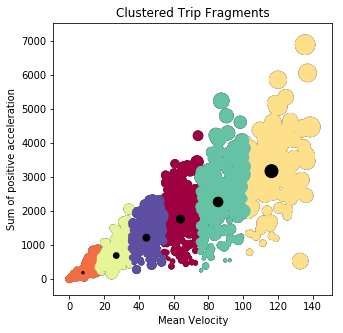

In [9]:
cluster_centers = cluster_trip_fragments(all_trips_cluster_input, eps=0.5, min_samples=5, n_clusters= 6, plot = True)

In [10]:
def assign_trip_fragments_to_clusters(local_my_trip_sorted, local_cluster_centers, interval = 60):
    
    min_range = int(local_my_trip_sorted['Time [s]'].min())
    max_range = int(local_my_trip_sorted['Time [s]'].max()) - interval

    local_my_trip_sorted['Cluster'] = -1

    for i in range(min_range,max_range,interval):
        mean_velocity = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval), 'Smoothed Velocity'].mean()
        diff_soc = float(local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] == i), 'SoC [%]']) - float(local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] == (i+interval)), 'SoC [%]'])
        pos_acc = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval) & (local_my_trip_sorted['Longitudinal Acceleration [m/s^2]'] > 0), 'Smoothed Velocity'].sum()
        neg_acc = local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval) & (local_my_trip_sorted['Longitudinal Acceleration [m/s^2]'] < 0), 'Smoothed Velocity'].sum()
    
        # Assign trip fragment to cluster
        cluster_assignment = -1
        min_distance = np.inf
        for cl in range(0, len(local_cluster_centers)):
            distance = math.sqrt((mean_velocity - local_cluster_centers[cl][0])**2 + 
                                 (diff_soc - local_cluster_centers[cl][1])**2 + 
                                 (pos_acc - local_cluster_centers[cl][2])**2 + 
                                 (neg_acc - local_cluster_centers[cl][3])**2)
        
            if (distance < min_distance):
                cluster_assignment = cl
                min_distance = distance
        
        local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] >= i) & (local_my_trip_sorted['Time [s]'] < i+interval), 'Cluster'] = cluster_assignment
    
    return local_my_trip_sorted

In [11]:
def plot_trip_with_clustered_fragments(local_my_trip_sorted):
    # Setting plot parameters
    plt.rcParams['figure.figsize'] = [70, 10]
    f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

    # Plotting trip velocity
    vel_ax.plot(local_my_trip_sorted['Time [s]'], local_my_trip_sorted['Velocity [km/h]'], color = 'black')

    # Set colors for plot
    unique_labels = set(local_my_trip_sorted['Cluster'].unique())
    colors = list()
    for c in np.linspace(0, 1, (max(unique_labels)+1)):
        colors.append(plt.cm.Spectral(c))
    
    # Plotting micro fragments of the trip
    ax.plot(local_my_trip_sorted['Time [s]'], local_my_trip_sorted['Smoothed Velocity'], color = 'black')

    ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Cluster'] == -1,
                    color='grey', alpha=0.5, transform=ax.get_xaxis_transform())
    
    for cl in local_my_trip_sorted['Cluster'].unique():
        if cl >= 0:            
            ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Cluster'] == cl,
                            color=colors[cl], alpha=0.5, transform=ax.get_xaxis_transform())
            
    # Adding auxilliary plot segments
    f.suptitle(('Clustered ' + my_trip_sorted['trip_id'].unique()[0]), fontsize=60)
            
    plt.show() 

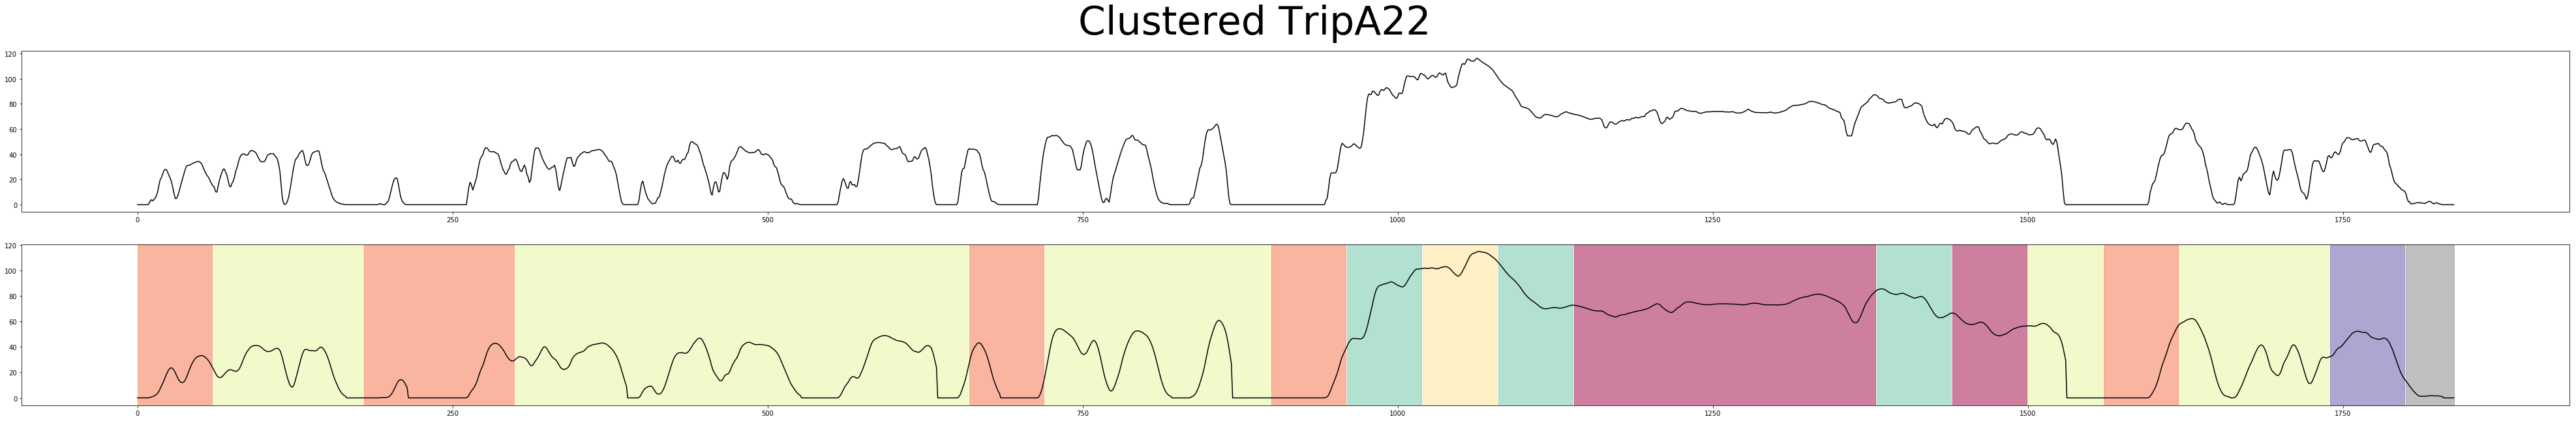

In [13]:
my_trip_sorted = extract_and_sort_trip('TripA22')
my_trip_sorted = smooth_trip_velocity(my_trip_sorted, local_smoothing_range = 10)
my_trip_sorted = assign_trip_fragments_to_clusters(my_trip_sorted, cluster_centers, interval = 60)
plot_trip_with_clustered_fragments(my_trip_sorted)

# What Remains to be Said

The data used within this Notebook has been downloaded from Kaggle (https://www.kaggle.com/atechnohazard/battery-and-heating-data-in-real-driving-cycles). It has originally been published by Matthias Steinstraeter (Technical University of Munich, Institute of Automotive Technology), Johannes Buberger (Technical University of Munich, Institute of Automotive Technology), and Dimitar Trifonov (Technical University of Munich, Institute of Automotive Technology) in IEEE Data Portal (https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles).

Author of this Notebook is: F B

Created in March 2022